In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import albumentations as a
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(123)
if device == 'cuda':
    torch.cuda.manual_seed_all(123)

# 이미지 데이터 전처리

In [2]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        # data augmentation
        self.data_transform = {
            # 훈련 이미지 데이터에 대한 전처리
            'train': a.Compose([
                a.Resize(resize,resize),
                a.Rotate(limit=20,border_mode=cv2.BORDER_CONSTANT),
                a.HorizontalFlip(p=0.4),
                a.VerticalFlip(p=0.4),
                a.RGBShift(25,25,25,p=0.9),
                a.OneOf([
                    a.Blur(blur_limit=10),
                    a.ColorJitter(0.3,0.3)
                ],p=0.8),
                a.Normalize(
                mean=mean,
                std=std,
                max_pixel_value=255),
                ToTensorV2(),
            ]),
            # 검증과 테스트 이미지 데이터에 대한 전처리
            'val': a.Compose([
                a.Resize(resize,resize),
                a.Normalize(
                    mean=mean,
                    std=std,
                    max_pixel_value=255),     
                ToTensorV2(),
            ])
        }
    
    def __call__(self, img, phase):
        return self.data_transform[phase](image=img)

In [3]:
# 데이터셋 불러오기
train_dir='./bird/train'
val_dir="./bird/valid"
test_dir="./bird/test"

train_images_dir_list = [os.path.join(train_dir, f) for f in os.listdir(train_dir)]
train_images_filepaths = [os.path.join(d, f) for d in train_images_dir_list for f in os.listdir(d)]

val_images_dir_list = [os.path.join(val_dir, f) for f in os.listdir(val_dir)]
val_images_filepaths = [os.path.join(d, f) for d in val_images_dir_list for f in os.listdir(d)]

test_images_dir_list = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]
test_images_filepaths = [os.path.join(d, f) for d in test_images_dir_list for f in os.listdir(d)]

In [4]:
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

9592 3165 3165


In [5]:
# 이미지 레이블링
image_labels = {f:i for i,f in enumerate(os.listdir(train_dir))}
image_labels

{'Baikal teal': 0,
 'Bean goose': 1,
 'Black-billed Magpie': 2,
 'Black-tailed Gull': 3,
 'Common Coot': 4,
 'Common Pochard': 5,
 'Common shelduck': 6,
 'Domestic pigeon': 7,
 'Eurasian tree sparrow': 8,
 'Greater Scaup': 9,
 'Greater White-fronted Goose': 10,
 'Mallard': 11,
 'Rook': 12,
 'Spot-billed Duck': 13,
 'Vega gull': 14}

In [6]:
# 이미지에 대한 레이블 구분
class BirdSpeciesDataset(Dataset):
    def __init__(self, file_list, image_labels, transform=None, phase='train'):
        self.file_list = file_list
        self.image_labels = image_labels
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img, self.phase)['image']    # image transform
        specie = self.file_list[idx].split('\\')[-2]
        label = self.image_labels[specie]
        return img, label

In [7]:
class ResizeTransform():
    def __init__(self, resize):
        self.data_transform = a.Compose([
        a.Resize(resize,resize),
        ToTensorV2()
    ])
    
    def __call__(self, img, phase):
        return self.data_transform(image=img)

In [8]:
resize_train = BirdSpeciesDataset(train_images_filepaths, image_labels, transform=ResizeTransform(224))
resize_val = BirdSpeciesDataset(val_images_filepaths, image_labels, transform=ResizeTransform(224))

resize_train[0][0].shape

torch.Size([3, 224, 224])

In [9]:
size = 224
resize_train_mean=[0.485, 0.456, 0.406]
resize_train_std=[0.229, 0.224, 0.225]

resize_test_mean=[0.485, 0.456, 0.406]
resize_test_std=[0.229, 0.224, 0.225]
batch_size = 32

In [10]:
#test = BirdSpeciesDataset(train_images_filepaths[:10], image_labels, transform=ImageTransform(size,resize_train_mean,resize_train_std), phase='train')
#test = DataLoader(test, batch_size=10, shuffle=False)
# def show_transform_images(dataloader):
#     batch = next(iter(dataloader))
#     images, labels = batch
    
#     images = images / 2 + 0.5
#     grid = torchvision.utils.make_grid(images, nrow=3)
#     print(grid.size())
#     plt.figure(figsize=(100,100))
#     plt.imshow(np.transpose(grid,(1,2,0)))
#     print('labels: ',labels)

In [11]:
# 이미지 데이터셋 정의
train_dataset = BirdSpeciesDataset(train_images_filepaths, image_labels, transform=ImageTransform(size,resize_train_mean,resize_train_std), phase='train')
val_dataset = BirdSpeciesDataset(val_images_filepaths, image_labels, transform=ImageTransform(size,resize_test_mean,resize_test_std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].numpy().shape)
print(train_dataset.__getitem__(index)[1])

(3, 224, 224)
0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 2488, 680])
labels:  tensor([13,  5, 10, 11,  6,  9, 11,  2,  5,  3,  4, 14, 11,  3,  3,  6,  5, 13,
        10,  5,  8,  4,  0, 10,  1,  5,  8,  4,  9, 13,  2, 14])


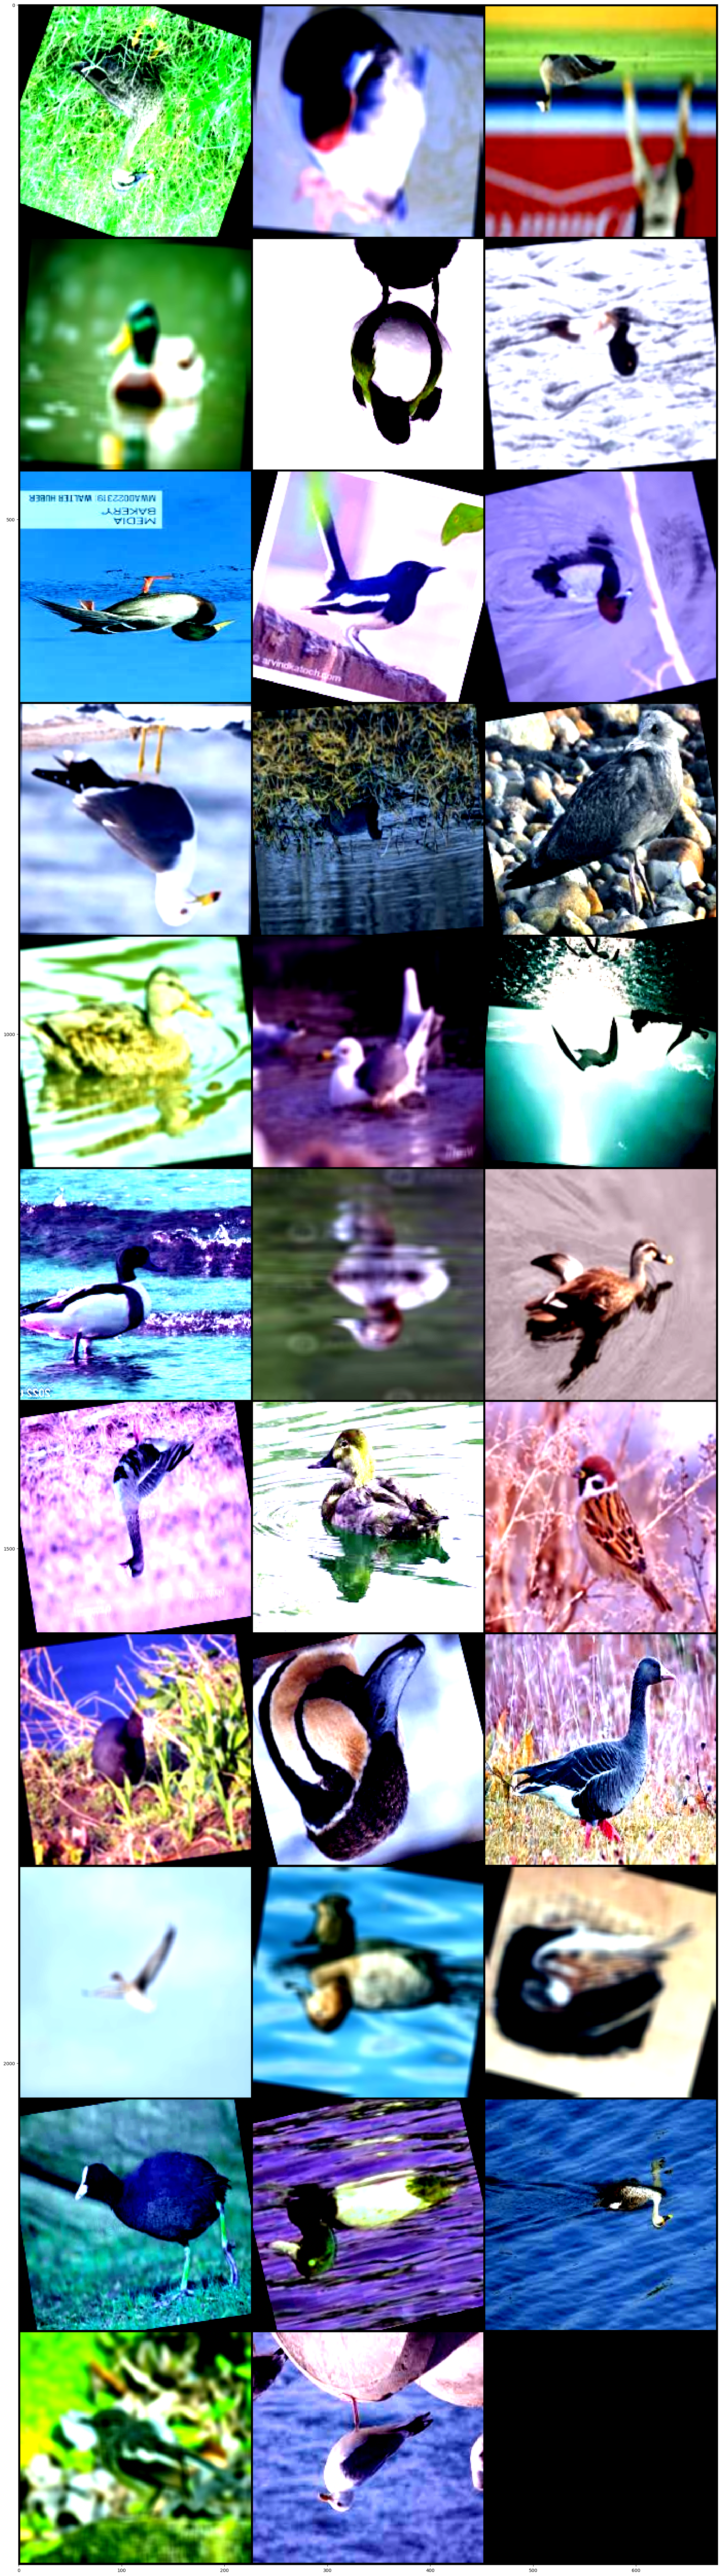

In [12]:
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

def show_transform_images(dataloader):
    batch = next(iter(dataloader))
    images, labels = batch
    
    images = images / 2 + 0.5
    grid = torchvision.utils.make_grid(images, nrow=3)
    print(grid.size())
    plt.figure(figsize=(100,100))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ',labels)

show_transform_images(train_iterator)

# 모델 학습

In [13]:
model = models.resnet18(pretrained=True)

#resnet50 = models.wide_resnet50_2(pretrained=True)

# for param in resnet50.parameters():
#     param.requires_grad = False

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 15)
# for param in resnet50.fc.parameters():
#     param.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
#criterion.to(device)

optimizer_ft = optim.AdamW(model.parameters(), lr=0.0008)

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# 모델 학습 정확도 측정 함수
def calculate_topk_accuracy(y_pred, y, k = 15):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)    # k에서 가장 큰 값의 index
        top_pred = top_pred.t()    # 전치
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))    # tensor 비교 후 같으면 True, 다르면 False 반환
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)    # 이미지의 정확한 레이블 부여를 위해 사용
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [15]:
# 모델 학습 함수
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()    
    for (x, y) in iterator:
#         grid = torchvision.utils.make_grid(x, nrow=3)
#         plt.figure(figsize=(100,100))
#         plt.imshow(np.transpose(grid,(1,2,0)))
#         print(y)
#         input()
    
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        
        #print(y_pred)
        #print(y)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()    # 모델이 첫 번째로 예측한 레이블
        epoch_acc_5 += acc_5.item()    # 이미지에 정확한 레이블
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [16]:
# 모델 평가 함수
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)    
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [17]:
# 모델 학습 시간 측정 함수
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
# 모델 학습
best_valid_loss = float('inf')
EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(EPOCHS):    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer_ft, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './data/ResNet-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc_1)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc_1)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

C:\Users\User\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 1m 18s
	Train Loss: 1.338 | Train Acc @1:  55.10% | Train Acc @5: 100.00%
	Valid Loss: 1.164 | Valid Acc @1:  63.23% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 1m 18s
	Train Loss: 0.959 | Train Acc @1:  66.98% | Train Acc @5: 100.00%
	Valid Loss: 0.849 | Valid Acc @1:  70.06% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 1m 18s
	Train Loss: 0.806 | Train Acc @1:  72.46% | Train Acc @5: 100.00%
	Valid Loss: 0.843 | Valid Acc @1:  71.83% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 1m 17s
	Train Loss: 0.727 | Train Acc @1:  75.31% | Train Acc @5: 100.00%
	Valid Loss: 0.788 | Valid Acc @1:  74.60% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 1m 17s
	Train Loss: 0.661 | Train Acc @1:  77.54% | Train Acc @5: 100.00%
	Valid Loss: 0.768 | Valid Acc @1:  74.90% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 1m 16s
	Train Loss: 0.633 | Train Acc @1:  78.96% | Train Acc @5: 100.00%
	Valid Loss: 0.671 | Valid Acc @1:  77.84% | Valid Acc @5: 100.00%
Epoch: 07 

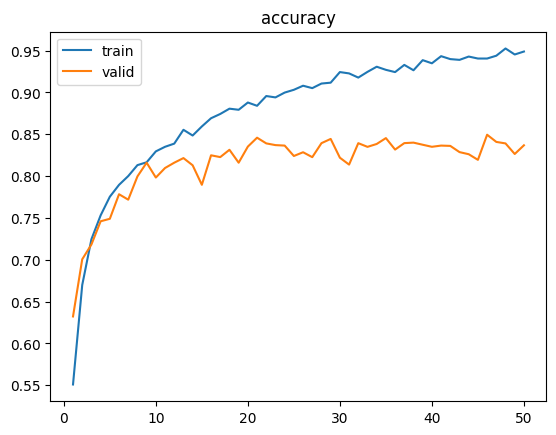

In [22]:
# 정확도
plt.title('accuracy')
#plt.xticks(range(1,EPOCHS+1))
plt.plot(range(1,EPOCHS+1), train_acc_list, label='train')
plt.plot(range(1,EPOCHS+1), valid_acc_list, label='valid')
plt.legend()
plt.show()

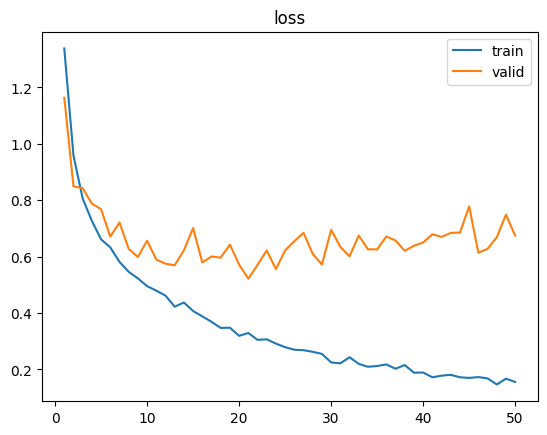

In [23]:
# 손실률
plt.title('loss')
#plt.xticks(range(1,EPOCHS+1))
plt.plot(range(1,EPOCHS+1), train_loss_list, label='train')
plt.plot(range(1,EPOCHS+1), valid_loss_list, label='valid')
plt.legend()
plt.show()

# 모델 예측

In [25]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 15)
model = model.to(device)

model.load_state_dict(torch.load("./data/ResNet-model.pt"))
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
import pandas as pd
id_list = []
pred_list = []
percent_list = []
_id=0
success = 0
with torch.no_grad():
    for test_path in test_images_filepaths:
        img = cv2.imread(test_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        _id ='/'.join(test_path.split('\\')[1:])
        transform = ImageTransform(size, resize_test_mean, resize_test_std)
        img = transform(img, phase='val')['image']
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs[0], dim=0).tolist()
        id_list.append(_id)
        preds_percent = max(preds)
        percent_list.append(preds_percent)
        preds_label = preds.index(preds_percent)
        pred_list.append(preds_label)
        
        specie = _id.split('/')[0]
        label = image_labels[specie]
        if preds_label == label:
            success += 1

print(f'\tTrain Test @1: {(success/len(test_images_filepaths))*100:6.2f}%')

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list,
    'percent': percent_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('./data/ReNet.csv', index=False)
res.head(10)

	Train Test @1:  79.75%


id  label   percent
0  Baikal teal/0000.jpg      0  0.999835
1  Baikal teal/0001.jpg      0  0.999999
2  Baikal teal/0002.jpg      0  0.999941
3  Baikal teal/0003.jpg      0  0.999997
4  Baikal teal/0004.jpg      0  0.999995
5  Baikal teal/0005.jpg      0  0.999940
6  Baikal teal/0006.jpg      0  0.999977
7  Baikal teal/0007.jpg      0  0.999997
8  Baikal teal/0008.jpg      0  0.780782
9  Baikal teal/0009.jpg      0  0.989138

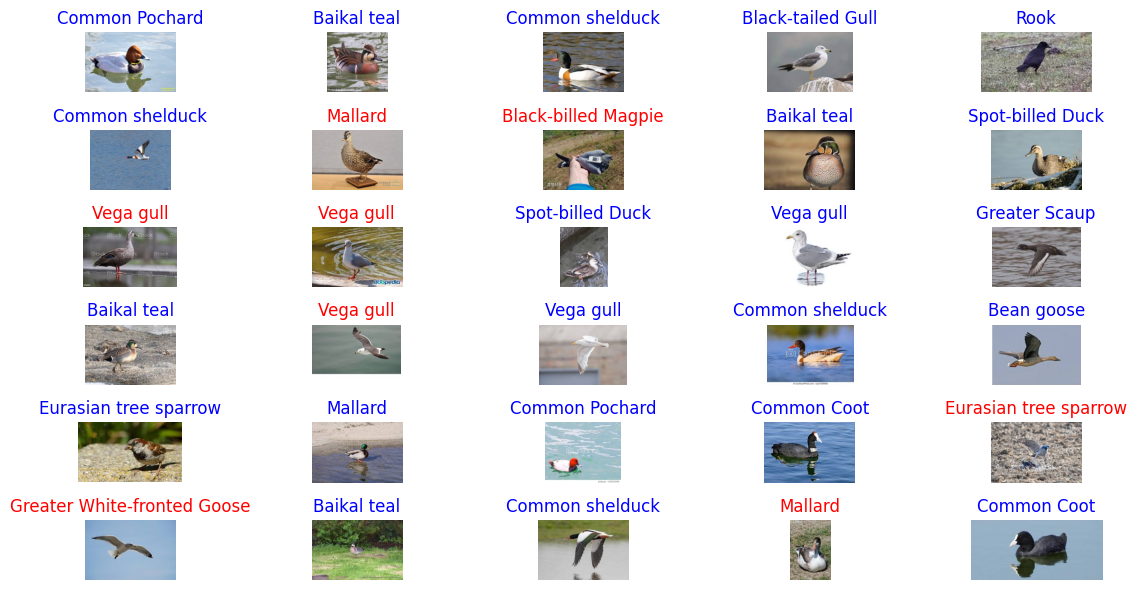

In [27]:
random.seed(123)
class_ = classes = {i:f for f,i in image_labels.items()}


def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    paths = images_filepaths[:]
    random.shuffle(paths)
    paths = paths[:30]     # random으로 30장 사진 출력
    rows = len(paths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(paths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        tmp = image_filepath.split('\\')[1:]
        res_id = '/'.join(tmp)
        label = res.loc[res['id'] == res_id, 'label'].values[0]
        
        ax.ravel()[i].imshow(image)
        if class_[label] == tmp[0]:
            ax.ravel()[i].set_title(class_[label],color= 'blue')
        else:
            ax.ravel()[i].set_title(class_[label], color= 'red')
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths) 